Libraries Import

In [1]:
#library for understanding music
from music21 import *
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import LSTM,Dense, Dropout
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split

2022-07-17 18:15:42.709159: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-17 18:15:42.709191: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Parse and Read Midi Files

In [2]:
def read_midi_file(file):
    notes = []
    notes_to_parse = None

    #parsing a midi file
    midi = converter.parse(file)

    #grouping based on different instruments
    ins = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in ins.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
    return notes

#specify the path
path='All Midi Files/albeniz/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi_file(path+i) for i in tqdm(files)])

  0%|          | 0/14 [00:00<?, ?it/s]/home/puli/SoC/musify/musify-env/lib/python3.9/site-packages/music21/midi/translate.py:883: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2001 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
100%|██████████| 14/14 [01:11<00:00,  5.13s/it]
/tmp/ipykernel_19640/2725945799.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  notes_array = np.array([read_midi_file(path+i) for i in tqdm(files)])


Understanding the Data 

No. of unique notes:  248

Frequency notes
30 : 124
50 : 92
70 : 71
90 : 53


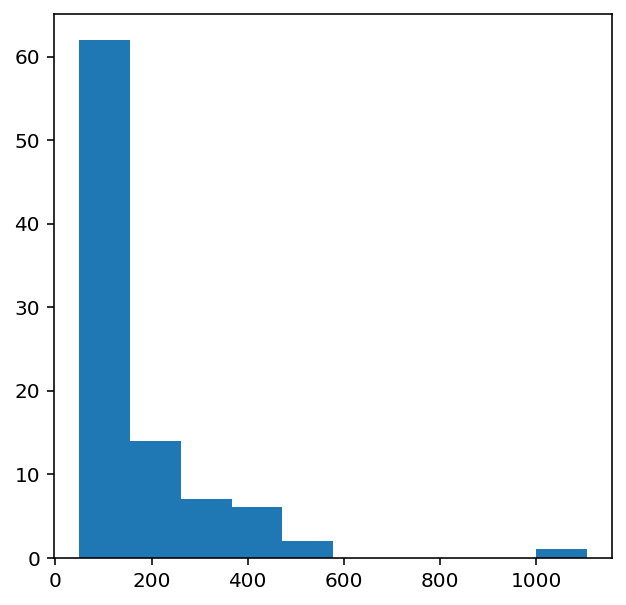

In [3]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print("No. of unique notes: ", len(unique_notes))

#notes with their frequency
freq=dict(map(lambda x: (x,notes_.count(x)),unique_notes))

#get the threshold frequency
print("\nFrequency notes")
for i in range(30,100,20):
  print(i,":",len(list(filter(lambda x:x[1]>=i,freq.items()))))

#filter notes greater than threshold i.e. 50
freq_notes=dict(filter(lambda x:x[1]>=50,freq.items()))

# consider only the frequencies
no=[count for _, count in freq_notes.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

#create new notes using the frequent notes
new_music=[[note_ for note_ in notes if note_ in freq_notes] for notes in notes_array]

#dictionary having key as note index and value as note
ind2note=dict(enumerate(freq_notes))

#dictionary having key as note and value as note index
note2ind=dict(map(reversed,ind2note.items()))


Preparing the input and output sequences 

In [4]:
no_of_timesteps = 35

#store values of input and output
x=[]
y=[]

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        #input will be the current index + timestep
        #output will be the next index after timestep

        inp = note_[i:i + no_of_timesteps]
        out = note_[i + no_of_timesteps]
        
        x.append(list(map(lambda x:note2ind[x],inp)))
        y.append(note2ind[out])
        
x=np.array(x)
y=np.array(y)

Training and Testing Data

In [5]:
#reshape input and output for the model
x_seq = np.reshape(x,(len(x),no_of_timesteps,1))
y_seq = np.reshape(y,(-1,1))

#split the input and value into training and testing sets
#80% for training and 20% for testing sets
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size=0.2, random_state=42)

Model Building

In [6]:
#create the model
model = Sequential()
#create two stacked LSTM layer with the latent dimension of 256
model.add(LSTM(256,return_sequences=True,input_shape=(x_seq.shape[1],x_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))

#fully connected layer for the output with softmax activation
model.add(Dense(len(note2ind),activation='softmax'))
model.summary()

2022-07-17 18:17:45.555147: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-17 18:17:45.555258: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Puli): /proc/driver/nvidia/version does not exist
2022-07-17 18:17:45.823100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 256)           264192    
                                                                 
 dropout (Dropout)           (None, 35, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 92)                23644     
                                                                 
Total params: 878,940
Trainable params: 878,940
Non-trai

Training the Model

In [7]:
#compile the model using Adam optimizer
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#train the model on training sets and validate on testing sets
model.fit(
    x_train,y_train,
    batch_size=128,epochs=50,
    validation_data=(x_test,y_test))

Epoch 1/50
92/92 [==============================] - 50s 473ms/step - loss: 4.2195 - accuracy: 0.0740 - val_loss: 4.1822 - val_accuracy: 0.0637
Epoch 2/50
92/92 [==============================] - 42s 455ms/step - loss: 4.1235 - accuracy: 0.0775 - val_loss: 4.1140 - val_accuracy: 0.0658
Epoch 3/50
92/92 [==============================] - 49s 529ms/step - loss: 4.0524 - accuracy: 0.0811 - val_loss: 4.0539 - val_accuracy: 0.0750
Epoch 4/50
92/92 [==============================] - 48s 519ms/step - loss: 3.9511 - accuracy: 0.0945 - val_loss: 3.9147 - val_accuracy: 0.0961
Epoch 5/50
92/92 [==============================] - 47s 514ms/step - loss: 3.8209 - accuracy: 0.1115 - val_loss: 3.8061 - val_accuracy: 0.1155
Epoch 6/50
92/92 [==============================] - 49s 536ms/step - loss: 3.6922 - accuracy: 0.1342 - val_loss: 3.6888 - val_accuracy: 0.1288
Epoch 7/50
92/92 [==============================] - 57s 616ms/step - loss: 3.5428 - accuracy: 0.1553 - val_loss: 3.5575 - val_accuracy: 0.1626

In [8]:
#saving the Model
model.save("MODEL")

INFO:tensorflow:Assets written to: MODEL/assets


INFO:tensorflow:Assets written to: MODEL/assets


Interference Phase

In [9]:
#load the model
model=load_model("MODEL")
#generate random index
index = np.random.randint(0,len(x_test)-1)
#get the data of generated index from x_test
music_pattern = x_test[index]

out_pred=[] #it will store predicted notes

#iterate till 200 note is generated
for i in range(200):

  #reshape the music pattern 
  music_pattern = music_pattern.reshape(1,len(music_pattern),1)
  
  #get the maximum probability value from the predicted output
  pred_index = np.argmax(model.predict(music_pattern))
  #get the note using predicted index and
  #append to the output prediction list
  out_pred.append(ind2note[pred_index])
  music_pattern = np.append(music_pattern,pred_index)
  
  #update the music pattern with one timestep ahead
  music_pattern = music_pattern[1:]

1/1 [==============================] - 0s 34ms/step


File Saving

In [10]:
output_notes = []
for offset,pattern in enumerate(out_pred):
  #if pattern is a chord instance
  if ('.' in pattern) or pattern.isdigit():
    #split notes from the chord
    notes_in_chord = pattern.split('.')
    notes = []
    for current_note in notes_in_chord:
        i_curr_note=int(current_note)
        #cast the current note to Note object and
        #append the current note 
        new_note = note.Note(i_curr_note)
        new_note.storedInstrument = instrument.Piano()
        notes.append(new_note)
    
    #cast the current note to Chord object
    #offset will be 1 step ahead from the previous note
    #as it will prevent notes to stack up 
    new_chord = chord.Chord(notes)
    new_chord.offset = offset
    output_notes.append(new_chord)
  
  else:
    #cast the pattern to Note object apply the offset and 
    #append the note
    new_note = note.Note(pattern)
    new_note.offset = offset
    new_note.storedInstrument = instrument.Piano()
    output_notes.append(new_note)

#save the midi file 
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='AI_composed_music.mid')

'AI_composed_music.mid'